In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# Import libraries
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [ ]:
# # prompt: unzip this /content/drive/MyDrive/Capstone/Destination Banyumas.zip also this /content/drive/MyDrive/Capstone/Food Banyumas.zip, only imported required only and unzip in that folder

# import zipfile

# # Specify the paths to the zip files and the extraction directory.
# zip_file1_path = '/content/drive/MyDrive/Capstone/Destination Banyumas.zip'
# zip_file2_path = '/content/drive/MyDrive/Capstone/Food Banyumas.zip'
# extraction_dir = '/content/drive/MyDrive/Capstone/'


# # Function to unzip a file to a specified directory.
# def unzip_file(zip_file_path, extraction_dir):
#   with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extraction_dir)


# # Unzip the first file.
# unzip_file(zip_file1_path, extraction_dir)

# # Unzip the second file.
# unzip_file(zip_file2_path, extraction_dir)


In [ ]:
# prompt: split banyumas food into 2 train test, do simpler cod with split-dataset library

!pip install split-folders

import splitfolders

# Define the input and output directories
input_folder = '/content/drive/MyDrive/Capstone/Destination Banyumas'
output_folder = '/content/drive/MyDrive/Capstone/Destination Banyumas_split'

# Split the data into train and test sets (80% train, 20% test)
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.8, .2))

Copying files: 341 files [03:56,  1.44 files/s]


In [ ]:
# Dataset paths
train_dir = '/content/drive/MyDrive/Capstone/Destination Banyumas_split/train'
test_dir = '/content/drive/MyDrive/Capstone/Destination Banyumas_split/test'

In [ ]:
import os

def count_images_in_folders(root_dir):
  """Counts the number of images in subfolders of a given directory.

  Args:
    root_dir: The path to the root directory.

  Returns:
    A dictionary where keys are subfolder names and values are the number of images
    in each subfolder.
  """
  image_counts = {}
  for subdir, _, files in os.walk(root_dir):
    if subdir != root_dir:  # Skip the root directory itself
      class_name = os.path.basename(subdir)
      image_count = sum(1 for file in files if file.lower().endswith(('.png', '.jpg', '.jpeg'))) # Count image files
      image_counts[class_name] = image_count
  return image_counts


# Example usage for the training set
train_dir = '/content/drive/MyDrive/Capstone/Destination Banyumas_split/train'
train_distribution = count_images_in_folders(train_dir)
print("Distribution of images in the training set:")
for class_name, count in train_distribution.items():
  print(f"{class_name}: {count} images")


# Example usage for the validation set
test_dir = '/content/drive/MyDrive/Capstone/Destination Banyumas_split/test'
test_distribution = count_images_in_folders(test_dir)
print("\nDistribution of images in the validation set:")
for class_name, count in test_distribution.items():
  print(f"{class_name}: {count} images")

Distribution of images in the training set:
Curug: 29 images
The Village Purwokerto: 32 images
Menggala Ranch: 28 images
Alun Alun Purwokerto: 60 images
Menara Pandang Teratai: 39 images
Taman Botani Baturraden: 25 images
Taman Mas Kemambang: 31 images

Distribution of images in the validation set:
Curug: 9 images
The Village Purwokerto: 6 images
Menggala Ranch: 7 images
Alun Alun Purwokerto: 15 images
Menara Pandang Teratai: 10 images
Taman Botani Baturraden: 8 images
Taman Mas Kemambang: 8 images


# Prepro

## Augmentation

In [ ]:
# Parameters
img_size = (299, 299)  # Required input size for Xception
batch_size = 32
epochs = 100
fine_tune_epochs = 20

# Data preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./299,
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./299)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 244 images belonging to 7 classes.
Found 63 images belonging to 7 classes.


## Class Weight

In [ ]:
from collections import Counter
class_counts = Counter(train_generator.classes)
total_images = sum(class_counts.values())
class_weights = {cls: total_images / count for cls, count in class_counts.items()}

In [ ]:
class_weights

{0: 4.066666666666666,
 1: 8.413793103448276,
 2: 6.256410256410256,
 3: 8.714285714285714,
 4: 9.76,
 5: 7.870967741935484,
 6: 7.625}

# Model

In [ ]:

# Define the Xception model
base_model = Xception(weights='imagenet', include_top=False, input_shape=(299, 299, 3))
base_model.trainable = False  # Freeze the base model

# Add custom classification layers
model = models.Sequential([
    base_model,
    layers.SpatialDropout2D(0.4),
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(512, activation='swish'),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(train_generator.num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)

# Train the model (Initial Training)
history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=epochs,
    callbacks=[early_stopping, lr_scheduler],
    class_weight = class_weights
)

# Unfreeze some layers in the base model for fine-tuning
base_model.trainable = True

# Freeze the first N layers of the base model
for layer in base_model.layers[:100]:  # Adjust the number as needed
    layer.trainable = False

# Recompile the model for fine-tuning
model.compile(
    optimizer=Adam(learning_rate=1e-5),  # Lower learning rate for fine-tuning
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tuning
fine_tune_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=fine_tune_epochs,
    callbacks=[early_stopping, lr_scheduler]
)




83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 10, 10, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout2d (SpatialDropout2D) │ (None, 10, 10, 2048)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │           3,591 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,924,399 (83.63 MB)

 Trainable params: 1,057,799 (4.04 MB)

 Non-trainable params: 20,866,600 (79.60 MB)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 6s/step - accuracy: 0.3046 - loss: 14.5089 - val_accuracy: 0.6667 - val_loss: 1.1784 - learning_rate: 0.0010
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 585ms/step - accuracy: 0.7066 - loss: 5.1162 - val_accuracy: 0.8254 - val_loss: 0.8874 - learning_rate: 0.0010
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 441ms/step - accuracy: 0.8545 - loss: 3.1019 - val_accuracy: 0.8889 - val_loss: 0.7201 - learning_rate: 0.0010
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 410ms/step - accuracy: 0.8876 - loss: 2.3432 - val_accuracy: 0.9206 - val_loss: 0.6328 - learning_rate: 0.0010
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 409ms/step - accuracy: 0.8529 - loss: 2.8757 - val_accuracy: 0.9365 - val_loss: 0.5709 - learning_rate: 0.0010
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 418ms/step - accuracy: 0.9020 - loss: 2.0748 - val_accuracy: 0.9206 - val_loss: 0.5238 - learning_rate: 0.0010
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 409ms/step - accuracy: 0.8791 - loss: 2.2434 - val_accuracy: 

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 484ms/step - accuracy: 0.8948 - loss: 0.3402
Test Accuracy: 90.48%


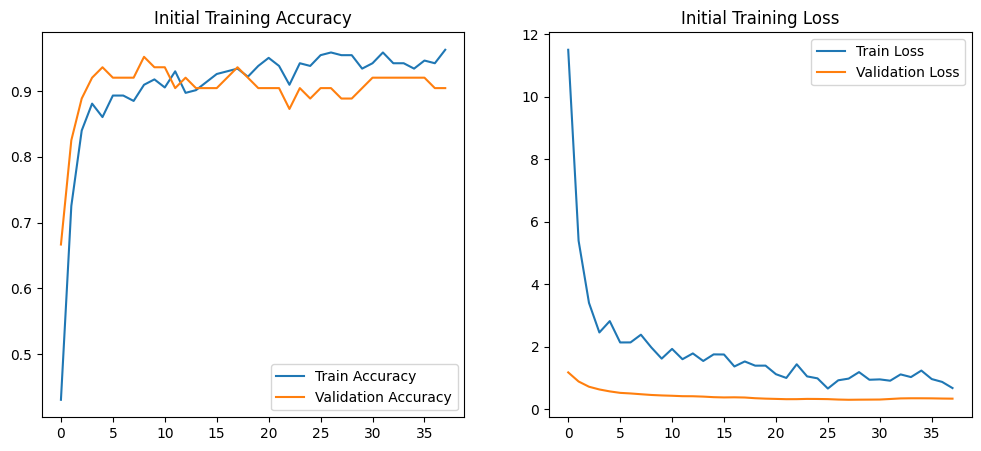

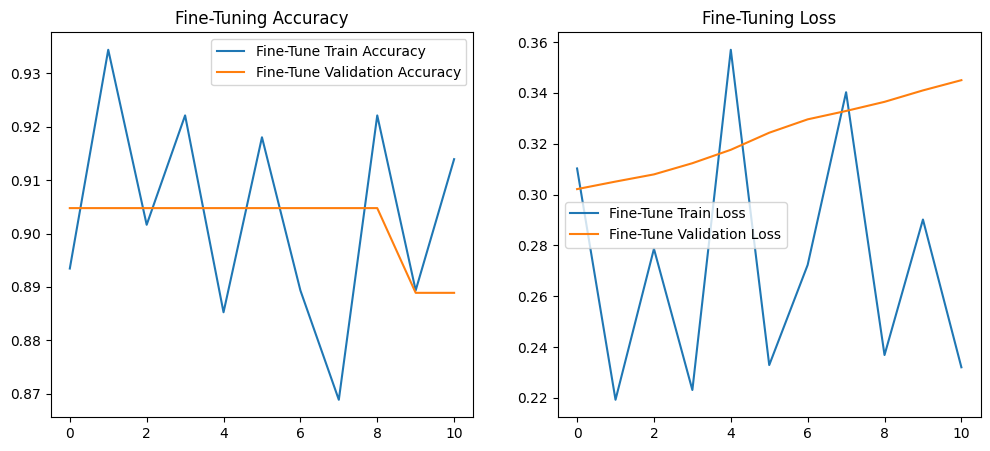

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the model

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Initial Training Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Initial Training Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Fine-Tune Train Accuracy')
plt.plot(fine_tune_history.history['val_accuracy'], label='Fine-Tune Validation Accuracy')
plt.title('Fine-Tuning Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Fine-Tune Train Loss')
plt.plot(fine_tune_history.history['val_loss'], label='Fine-Tune Validation Loss')
plt.title('Fine-Tuning Loss')
plt.legend()
plt.show()

# Model Save

In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Capstone/exception_Banyumas_destination_final.h5')

In [ ]:
# prompt: # Save the model
# model.save('/content/drive/MyDrive/exception_Banyumas_food_final.h5')
# convert to tflite

import tensorflow as tf

# Load the saved model
model = tf.keras.models.load_model('/content/drive/MyDrive/Capstone/exception_Banyumas_destination_final.h5')

# Convert the model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the TFLite model
with open('/content/drive/MyDrive/Capstone/exception_Banyumas_Destination_final.tflite', 'wb') as f:
  f.write(tflite_model)

Saved artifact at '/tmp/tmpamgi8z8b'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 299, 299, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  135222620817888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620829328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620831440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620824752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620827040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620825808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620440528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620438592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620439472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  135222620441056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1352226204454